# Beating the bookies : a step further

In 2017, KAUNITZ Lisandro, ZHONG Shenjun and KREINER Javier published an article called "Beating the bookies with their own numbers-and how the online sports betting market is rigged" link: https://arxiv.org/pdf/1710.02824.pdf

In this article, they describe how online bookmakers have exceptionnal models to predict games outcomes before they are played, and that they use these models to select the odds they will provide to the public to bet on.

Their theory was that we, as sports gamblers, could take advantage of that, and the fact that different companies have different models, to find outliers in odd distribution and bet on those.
I'll let you read the paper if you want more details.

So, in this notebook, we will try to go a step further. Their method is based on the closing odds given right before a game starts. But what if we could predict which games will have outliers in their odds distribution before the odds are even dealt ? What if we could accurately predict which game to bet on based on previous ones ?

Let's find out !

In [1]:
import pandas as pd
from matplotlib import pyplot as pl
import numpy as np
import seaborn as sns

C:\Users\remib\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\remib\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
C:\Users\remib\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The data we will be using comes from the authors kaggle dataset. Link here : https://www.kaggle.com/datasets/austro/beat-the-bookie-worldwide-football-dataset

In [2]:
Closing_Odds_df = pd.read_csv("closing_odds.csv")
Closing_Odds=Closing_Odds_df.copy()
Closing_Odds

,match_id,league,match_date,home_team,home_score,away_team,away_score,avg_odds_home_win,avg_odds_draw,avg_odds_away_win,max_odds_home_win,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win
0,170088,England: Premier League,2005-01-01,Liverpool,0,Chelsea,1,2.9944,3.1944,2.2256,3.20,3.25,2.29,Paddy Power,Sportingbet,Expekt,9,9,9
1,170089,England: Premier League,2005-01-01,Fulham,3,Crystal Palace,1,1.9456,3.2333,3.6722,2.04,3.30,4.15,Pinnacle Sports,bet-at-home,Expekt,9,9,9
2,170090,England: Premier League,2005-01-01,Aston Villa,1,Blackburn,0,1.8522,3.2611,4.0144,2.00,3.40,4.50,Pinnacle Sports,Paddy Power,Sportingbet,9,9,9
3,170091,England: Premier League,2005-01-01,Bolton,1,West Brom,1,1.6122,3.4133,5.4722,1.67,3.57,6.27,Coral,Pinnacle Sports,Pinnacle Sports,9,9,9
4,170092,England: Premier League,2005-01-01,Charlton,1,Arsenal,3,5.9878,3.4778,1.5567,7.00,3.60,1.62,Expekt,Paddy Power,bet365,9,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479435,876806,World: Club Friendly,2015-06-30,St. Gallen,1,Wacker Innsbruck,2,1.6838,3.8846,3.9813,1.83,4.20,4.33,188BET,bet365,Ladbrokes,24,24,24
479436,876807,World: Club Friendly,2015-06-30,SW Harelbeke,1,Waregem,1,13.1165,7.8229,1.1053,19.00,9.00,1.13,BetVictor,bet365,Titanbet,17,17,17
479437,876808,World: Club Friendly,2015-06-30,Torhout,0,Club Brugge,5,17.2256,12.6231,1.0288,22.00,15.00,1.05,BetVictor,Jetbull,BetVictor,16,16,16
479438,876809,World: Club Friendly,2015-06-30,Tournai,0,Mouscron Peruwelz,3,15.7143,10.2857,1.0614,34.00,12.00,1.10,Sportingbet,Betclic,Paddy Power,7,7,7


# PLAN :

### I - Overall exploratory analysis of the data
- Distribution of results and goals
- Year by Year analysis
- Bookmaker companies analysis
- Geographical (leagues/countries) analysis

### II - Introduction of the paper's strategy
- Second overall analysis based on the paper's inputs
- Feature Engineering

### III - Models
- Models choice and training
- Results evaluations and conclusions


Before we develop a model and dive deep into the paper's strategy, we should get comfortable with our data, try to anticipate potential biases in the data collection, highlight tendencies and detect data that need cleaning/transforming.


## I - Overall exploratory analysis 

First, we add result column to the dataset, to save us time when checking game outcomes. 

In [3]:
result = 1 * (Closing_Odds['home_score'] > Closing_Odds['away_score']) \
       - 1 * (Closing_Odds['home_score'] < Closing_Odds['away_score'])
        # + 0 * (Closing_Odds['home_score'] == Closing_Odds['away_score'])

#My result column : 1 for H, 0 for D and -1 for A

    
Closing_Odds.insert(7 ,'result' , result)

Closing_Odds

,match_id,league,match_date,home_team,home_score,away_team,away_score,result,goal_difference,avg_odds_home_win,...,avg_odds_away_win,max_odds_home_win,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win
0,170088,England: Premier League,2005-01-01,Liverpool,0,Chelsea,1,-1,-1,2.9944,...,2.2256,3.20,3.25,2.29,Paddy Power,Sportingbet,Expekt,9,9,9
1,170089,England: Premier League,2005-01-01,Fulham,3,Crystal Palace,1,1,2,1.9456,...,3.6722,2.04,3.30,4.15,Pinnacle Sports,bet-at-home,Expekt,9,9,9
2,170090,England: Premier League,2005-01-01,Aston Villa,1,Blackburn,0,1,1,1.8522,...,4.0144,2.00,3.40,4.50,Pinnacle Sports,Paddy Power,Sportingbet,9,9,9
3,170091,England: Premier League,2005-01-01,Bolton,1,West Brom,1,0,0,1.6122,...,5.4722,1.67,3.57,6.27,Coral,Pinnacle Sports,Pinnacle Sports,9,9,9
4,170092,England: Premier League,2005-01-01,Charlton,1,Arsenal,3,-1,-2,5.9878,...,1.5567,7.00,3.60,1.62,Expekt,Paddy Power,bet365,9,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479435,876806,World: Club Friendly,2015-06-30,St. Gallen,1,Wacker Innsbruck,2,-1,-1,1.6838,...,3.9813,1.83,4.20,4.33,188BET,bet365,Ladbrokes,24,24,24
479436,876807,World: Club Friendly,2015-06-30,SW Harelbeke,1,Waregem,1,0,0,13.1165,...,1.1053,19.00,9.00,1.13,BetVictor,bet365,Titanbet,17,17,17
479437,876808,World: Club Friendly,2015-06-30,Torhout,0,Club Brugge,5,-1,-5,17.2256,...,1.0288,22.00,15.00,1.05,BetVictor,Jetbull,BetVictor,16,16,16
479438,876809,World: Club Friendly,2015-06-30,Tournai,0,Mouscron Peruwelz,3,-1,-3,15.7143,...,1.0614,34.00,12.00,1.10,Sportingbet,Betclic,Paddy Power,7,7,7


[45.241114633739365, 24.98644251626898, 29.772442849991656]


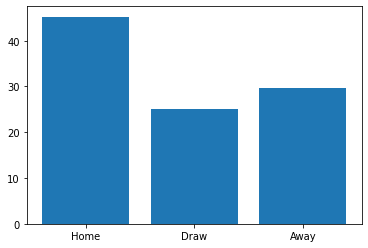

In [4]:
X = ['Home','Draw','Away']
Y = [100*len(Closing_Odds[Closing_Odds['result']>0])/len(Closing_Odds),
     100*len(Closing_Odds[Closing_Odds['result']==0])/len(Closing_Odds),
     100*len(Closing_Odds[Closing_Odds['result']<0])/len(Closing_Odds)]
print(Y)
pl.bar(X,Y)
pl.show()

45% of games end with the home team winning, ~25% end in draw and ~30% with the away team winning.

Onto goals now

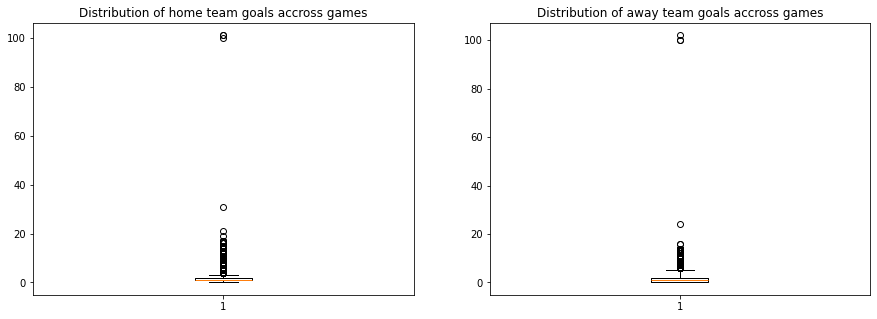

In [5]:
fig,(ax1,ax2) = pl.subplots(1,2, figsize=(15,5))

ax1.boxplot(list(Closing_Odds['home_score']))
ax2.boxplot(list(Closing_Odds['away_score']))

ax1.set_title('Distribution of home team goals accross games')
ax2.set_title('Distribution of away team goals accross games')

pl.show()

Well well well, 100 goals scored in one game, better check that out.

In [6]:
Closing_Odds[Closing_Odds['home_score']>30]

,match_id,league,match_date,home_team,home_score,away_team,away_score,result,goal_difference,avg_odds_home_win,...,avg_odds_away_win,max_odds_home_win,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win
10773,196028,Mexico: Primera Division,2005-08-13,Necaxa,101,U.N.A.M.- Pumas,0,1,101,2.1433,...,2.9033,2.20,3.30,3.00,Expekt,William Hill,bet365,6,6,6
60099,293927,Peru: Primera Division,2007-08-26,Alianza Atl.,101,Sport Ancash,1,1,100,1.9244,...,3.4478,2.00,3.20,3.50,bwin,bet-at-home,bet365,9,9,9
97404,362716,France: Coupe de France,2008-11-22,Haguenau,100,Dijon,102,-1,-2,7.9891,...,1.3536,9.00,4.00,1.37,Betclic,bet-at-home,Expekt,11,11,11
280577,617953,Romania: Romanian Cup,2012-08-28,Berceni,31,Academica Arges,0,1,31,1.7300,...,3.7500,1.73,3.75,3.75,Paddy Power,Paddy Power,Paddy Power,1,1,1


In [7]:
Closing_Odds[Closing_Odds['away_score']>20]

,match_id,league,match_date,home_team,home_score,away_team,away_score,result,goal_difference,avg_odds_home_win,...,avg_odds_away_win,max_odds_home_win,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win
30817,236985,Peru: Primera Division,2006-05-24,FBC Melgar,1,Jose Galvez,100,-1,-99,2.1000,...,3.0000,2.1,3.2,3.00,bet365,bet365,bet365,1,1,1
97404,362716,France: Coupe de France,2008-11-22,Haguenau,100,Dijon,102,-1,-2,7.9891,...,1.3536,9.0,4.0,1.37,Betclic,bet-at-home,Expekt,11,11,11
97409,362731,France: Coupe de France,2008-11-22,Saint-Omer,0,Amiens,100,-1,-100,11.4489,...,1.1700,14.0,6.0,1.26,Betsafe,bet365,10Bet,9,9,9
250126,579115,South Africa: Nedbank Cup,2012-03-04,Powerlines,0,Mamelodi Sundowns,24,-1,-24,17.7500,...,1.1000,19.0,7.5,1.11,Sportingbet,Sportingbet,bwin,4,4,4


After review :
- Necaxa - U.N.A.M. ended 2-0, 
- Alianza Atl. - Sport Ancash ended on a 1-1
- Haguenau - Dijon ended in a 0-1
- Berceni - Academica Arges really ended 31-0

- FBC Melgar - Jose Galvez ended on a 2-0
- Saint-Omer - Amiens ended 1-0
- Powerlines - Mamelodi Sundowns really ended 0-24

Let's correct the dataset's mistake and go from there

In [8]:
Closing_Odds.loc[10773,'home_score']=2
Closing_Odds.loc[10773,'away_score']=0

Closing_Odds.loc[60099,'home_score']=1
Closing_Odds.loc[60099,'away_score']=1

Closing_Odds.loc[97404,'home_score']=0
Closing_Odds.loc[97404,'away_score']=1

Closing_Odds.loc[30817,'home_score']=2
Closing_Odds.loc[30817,'away_score']=0

Closing_Odds.loc[97409,'home_score']=1
Closing_Odds.loc[97409,'away_score']=0

#Update result column
result_col = 1 * (Closing_Odds['home_score'] > Closing_Odds['away_score']) \
       - 1 * (Closing_Odds['home_score'] < Closing_Odds['away_score'])

Closing_Odds['result'] = result_col

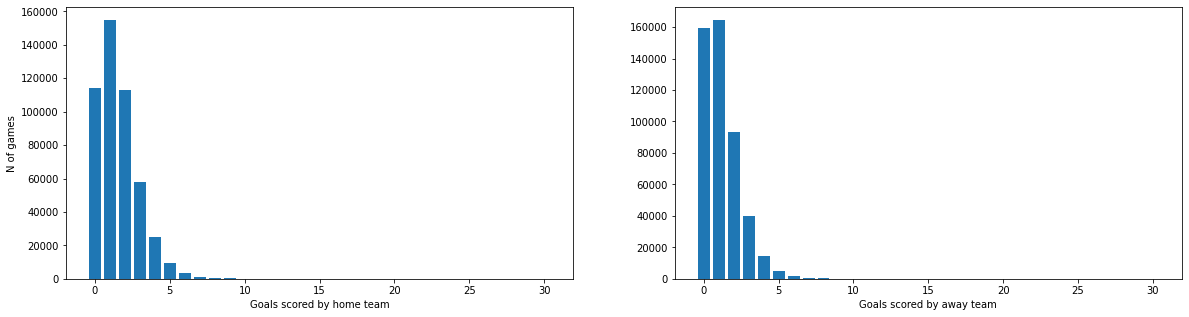

 Home teams score 1.538 goals on average, while away teams only score 1.2


In [9]:
X = range(max(Closing_Odds["home_score"]))
YH = []
YA = []

for x in X: 
    YH.append(len(Closing_Odds[Closing_Odds["home_score"]==x]))
    
for x in X:    
    YA.append(len(Closing_Odds[Closing_Odds["away_score"]==x])) 
 

fig,(ax1,ax2) = pl.subplots(1,2, figsize=(20,5))

ax1.bar(X,YH)
ax1.set_xlabel('Goals scored by home team')
ax1.set_ylabel('N of games')
ax2.bar(X,YA)
ax2.set_xlabel('Goals scored by away team')

pl.show()

print(f" Home teams score {round(np.mean(Closing_Odds['home_score']),3)} goals on average, while away teams only score {round(np.mean(Closing_Odds['away_score']),3)}")

#### - Year to year analysis : distribution of bets placed per year, and increase of competition in bookmakers

In [10]:
YEAR = []
for date in list(Closing_Odds["match_date"]):
   YEAR.append(int(date[:4]))

Closing_Odds.insert(3,'year',YEAR)

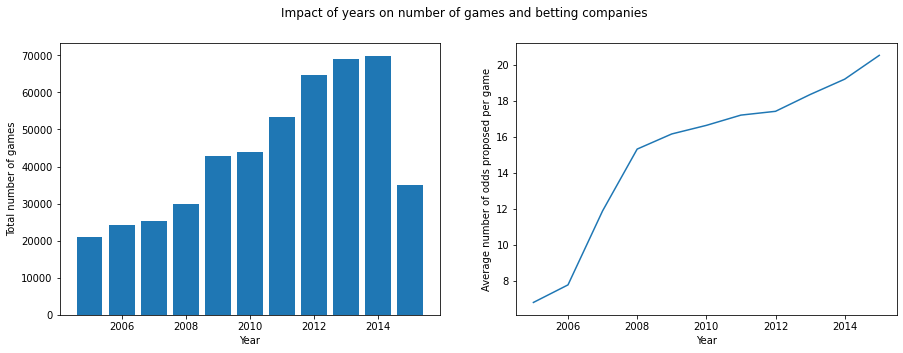

In [11]:
X = range(2005,2016)
Y1 = []
Y2 = []

for x in X:
    
    yearly_df = Closing_Odds[Closing_Odds["year"]==x]
    
    Y1.append(len(yearly_df))
    Y2.append(np.mean(yearly_df['n_odds_home_win'])) #Same averages for H/D/A in number of odds available.

fig,(ax1,ax2) = pl.subplots(1,2, figsize=(15,5))

fig.suptitle("Impact of years on number of games and betting companies")
ax1.bar(X,Y1)
ax1.set_ylabel("Total number of games")
ax1.set_xlabel("Year")

ax2.plot(X,Y2)
ax2.set_ylabel("Average number of odds proposed per game")
ax2.set_xlabel("Year")
pl.show()

Important to keep in mind : we have more games available in 2012 2013 and 2014 than any other years, by quite a large margin. 2005 to 2008 and 2015 are less filled.

Also, as we expected, there is an increase in odds available to chose from as years progress. Let's see if competition has an impact on those numbers.

#### - Betting companies : who's the most advantageous to bet on ? The least ?

Before looking at games with high amount of odds available and selecting the best one, we should look at the number of games with no bets available for one or more outcomes. Because it might give us some problem down the road.

In [46]:
pd.concat([Closing_Odds[Closing_Odds["n_odds_home_win"]==0],Closing_Odds[Closing_Odds["n_odds_away_win"]==0]]).head()

,match_id,country,league,match_date,year,home_team,home_score,away_team,away_score,result,...,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win,condition,country_encoded,league_encoded
7761,188788,Singapore,Singapore: S-League,2005-05-19,2005,Home Utd,0,Warriors,1,-1,...,3.4,0,18,18,0,1,1,False,101.0,611.0
7762,188789,Singapore,Singapore: S-League,2005-05-19,2005,Tampines,1,Young Lions,0,1,...,6.0,0,18,18,0,1,1,False,101.0,611.0
9140,192445,Singapore,Singapore: S-League,2005-06-24,2005,Woodlands W.,2,Young Lions,2,0,...,5.0,0,18,18,0,1,1,False,101.0,611.0
234040,559175,Denmark,Denmark: Elitedivisionen Women,2011-11-12,2011,Skovbakken W,9,Taastrup W,1,1,...,30.0,0,28,28,0,1,1,False,30.0,187.0
243382,570692,World,World: Olympic Games Women,2012-01-22,2012,Mexico W,7,Dominican Republic W,0,1,...,101.0,0,28,28,0,1,1,False,126.0,788.0
243441,570761,World,World: Olympic Games Women,2012-01-23,2012,USA W,13,Guatemala W,0,1,...,101.0,0,28,28,0,1,1,False,126.0,788.0
277039,613589,Europe,Europe: Champions League Women,2012-08-13,2012,Raciborz W,7,Ekonomist W,1,1,...,51.0,0,28,28,0,1,1,False,36.0,238.0
293794,634357,Europe,Europe: Euro U19 Women,2012-10-22,2012,Norway U19 W,2,Belarus U19 W,1,1,...,51.0,0,28,28,0,1,1,False,36.0,250.0
294210,634820,Europe,Europe: Euro U19 Women,2012-10-25,2012,Northern Ireland U19,4,Lithuania U19 W,0,1,...,41.0,0,28,28,0,1,1,False,36.0,250.0
298405,639992,Czech Republic,Czech Republic: First League Women,2012-11-11,2012,Sparta Prague W,4,Pardubice W,0,1,...,41.0,0,28,28,0,1,1,False,28.0,170.0


Games in which there are no odds for Home or Away Teams are very one-sided (so much that a 1.01 odd would still be losing money so better not propose at all). It's a little work around for our data analysis purposes but these games are still valuable and can't be deleted without care. Plus, it's probably an easy prediction to land for our future model. There are 28 instances of 0 bets for H, and 24 for A (none for Draw, you can always bet on draw, what a way to live life)

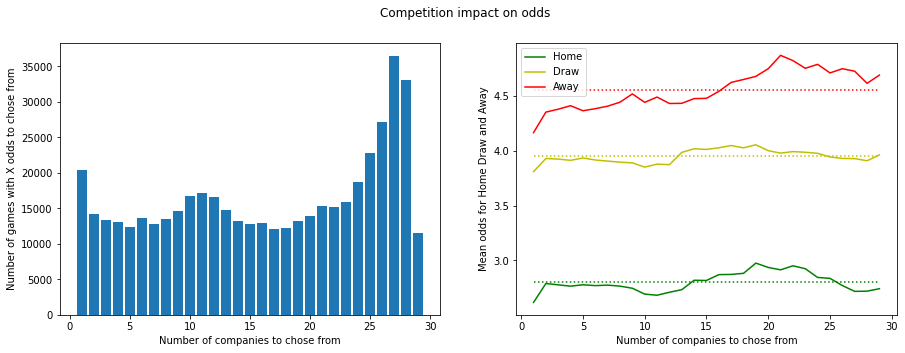

In [13]:
X = list(set(list(Closing_Odds["n_odds_home_win"])))
X=X[1:]
#Delete the 'NaN' occurences when no odds are available for a bet and we get the 29 bookmakers like advertised

Y=[]

H,D,A=[],[],[]
for x in X:
    Competition_df = Closing_Odds[Closing_Odds["n_odds_home_win"]==x]
    Y.append(len(Competition_df)) #Number of games played with X amount of odds to chose from 
    H.append(np.mean(Competition_df['max_odds_home_win'])) #Average odd for Home team Win per number of odds to choose from
    D.append(np.mean(Competition_df['max_odds_draw']))#-------------------- Draw ------------------------------------------
    A.append(np.mean(Competition_df['max_odds_away_win'])) #--------------- Away ------------------------------------------

    
    
fig,(ax1,ax2) = pl.subplots(1,2, figsize=(15,5))
fig.suptitle("Competition impact on odds")

ax1.bar(X,Y)
ax1.set_ylabel("Number of games with X odds to chose from")
ax1.set_xlabel("Number of companies to chose from")

ax2.plot(X,H,c="g", label="Home")
ax2.plot(X,D,c="y", label="Draw")
ax2.plot(X,A,c="r", label="Away")

ax2.hlines(np.mean(H),1,len(X),color='g',linestyle='dotted')
ax2.hlines(np.mean(D),1,len(X),color='y',linestyle='dotted')
ax2.hlines(np.mean(A),1,len(X),color='r',linestyle='dotted')


ax2.set_ylabel("Mean odds for Home Draw and Away")
ax2.set_xlabel("Number of companies to chose from")
ax2.legend()

pl.show()

Most games we collected have between 2 and 23 odds to chose from. Still, we've got plenty of games with 25 odds or more, which is a consequence of the 2 previous graphs we outlined : an increase of games played in 2013+ in our dataset, and the rise in betting companies accross time.

On the second graph, we observe no noticeable change for Home team and Draws, but a slight increase in odds for Away teams as competition rises. That's understandable, the best way for betting companies to separate themselves is by increasing odds of outcomes they deem unlikely, so their bigger numbers attract more clients while still keeping their profit margins relatively untouched.

Now we shall compare bookmakers numbers. Who gives us the best odds the most often ? Who's tightfisted ? 

In [14]:
Bookies = list(set(list(Closing_Odds["top_bookie_home_win"])+list(Closing_Odds["top_bookie_draw"])+list(Closing_Odds["top_bookie_away_win"])))
Bookies=Bookies[1:]



H,D,A=[],[],[]

for bm in Bookies:
    
    H.append(len(Closing_Odds[Closing_Odds["top_bookie_home_win"]==bm]))
    D.append(len(Closing_Odds[Closing_Odds["top_bookie_draw"]==bm]))
    A.append(len(Closing_Odds[Closing_Odds["top_bookie_away_win"]==bm]))

Best_H_BM = {}
Best_D_BM = {}
Best_A_BM = {}
Best_BM = {}

for i in range(len(Bookies)):
    
    Best_H_BM[Bookies[i]] = H[i]
    Best_D_BM[Bookies[i]] = D[i]
    Best_A_BM[Bookies[i]] = A[i]
    Best_BM[Bookies[i]] = H[i]+D[i]+A[i]
    


In [15]:
print("Best Bookmakers : ",sorted(Best_BM.items(), key=lambda x: x[1], reverse=True))
#print("Worst Bookmakers : ",sorted(Best_BM.items(), key=lambda x: x[1], reverse=False))

Best Bookmakers :  [('Pinnacle Sports', 202774), ('bet365', 182756), ('bwin', 131318), ('BetVictor', 91718), ('188BET', 83500), ('10Bet', 65051), ('Sportingbet', 59795), ('Expekt', 52418), ('Betsafe', 50107), ('bet-at-home', 47068), ('12BET', 45146), ('888sport', 41395), ('Tipico', 41160), ('Betway', 33553), ('SBOBET', 32219), ('Paddy Power', 29543), ('Coral', 27143), ('Betclic', 26871), ('Interwetten', 26765), ('Ladbrokes', 23577), ('Unibet', 23388), ('Betsson', 23190), ('William Hill', 23127), ('myBet', 22378), ('DOXXbet', 16224), ('ComeOn', 12172), ('Titanbet', 9503), ('youwin', 8015), ('Jetbull', 6394)]


Pinnacle Sports is the uncontested best bookmaker on the market. In ~480,000 games (meaning ~1,200,000 Odds to chose from), they have one of the best odds 200,000 times. This is quite impressive. 

#### - Geographical data : Where are our games played ? What leagues / countries are the most involved ? Does it have an impact on odds, or results ?

In [16]:
Countries_dict = {}
Leagues_dict = {}

Countries_list = []
Leagues_list = []

for league in list(Closing_Odds["league"]):

    country = league.split(": ")[0]
    Countries_list.append(country)
    Leagues_list.append(league)
    
    if country in Countries_dict:
        Countries_dict[country]+=1
    else:
        Countries_dict[country]=1
        
    if league in Leagues_dict:
        Leagues_dict[league]+=1
    else:
        Leagues_dict[league]=1
        

print(f"{len(Closing_Odds)} games")
print(f"{len(set(Closing_Odds['league']))} different leagues")
print(f"{len(Countries_dict)} different countries")


479440 games
818 different leagues
129 different countries


In [17]:
sorted(Countries_dict.items(), key=lambda x: x[1], reverse=True)[:15]

[('England', 45000),
 ('Germany', 32037),
 ('World', 24402),
 ('Italy', 21920),
 ('Spain', 19171),
 ('Turkey', 14196),
 ('France', 14070),
 ('Europe', 12998),
 ('Norway', 11655),
 ('Russia', 11060),
 ('Denmark', 9752),
 ('Czech Republic', 9002),
 ('Scotland', 8946),
 ('Belgium', 8941),
 ('Austria', 8733)]

In [18]:
sorted(Leagues_dict.items(), key=lambda x: x[1], reverse=True)[:15]

[('World: Club Friendly', 14106),
 ('England: League Two', 5283),
 ('England: League One', 5277),
 ('England: Championship', 5260),
 ('World: Friendly International', 5105),
 ('Italy: Serie B', 4481),
 ('Spain: Segunda Division', 4439),
 ('Argentina: Primera Division', 4024),
 ('Netherlands: Eerste Divisie', 3772),
 ('Italy: Serie A', 3643),
 ('Chile: Primera Division', 3637),
 ('Spain: Primera Division', 3630),
 ('France: Ligue 1', 3609),
 ('France: Ligue 2', 3608),
 ('England: Premier League', 3602)]

We have a huge focus on english football, with 45,000 games to chose from. Second is Germany, with ~32,000 and then there is a big drop, with World, Italy, Spain and France all below 24,000, almost half the amount of English games. 

In terms of leagues, what we have most of is world friendlies. 

I thought it would be beneficial to separate the league column into the 2 separate entities country & league alone, but it wouldn't tell the full story, as some countries have the same league names. For example, almost every spanish speaking country's first division is called 'Primera Division'.
So I will add a country column, just to get the information more accessible, but keep the league column as is.

In [19]:
Closing_Odds.insert(1,'country',Countries_list)

### II - Introduction of the paper's strategy :

Kaunitz, Zhong & Kreiner (2017) develop a way to find the most attractive odds and bet onyl on positive EV, basing their method on the high propensity for bookmakers' models to accurately predict games results.
Their way of coming to the final formula is highlighted in detail in the paper, for now let's jump right in

#### Formula (Eq7) :  max(Ω) > 1/pcons - α <=> (1/avg(Ω) - α)*max(Ω) -1 > 0


(If at least 3 odds available, else do not bet)

In [ ]:
alpha = 0.05

In [24]:
Home_condition = ((1/Closing_Odds['avg_odds_home_win']-alpha)*Closing_Odds['max_odds_home_win']-1>0) & (Closing_Odds['n_odds_home_win']>3)

Draw_condition = ((1/Closing_Odds['avg_odds_draw']-alpha)*Closing_Odds['max_odds_draw']-1>0) & (Closing_Odds['n_odds_draw']>3)

Away_condition = ((1/Closing_Odds['avg_odds_away_win']-alpha)*Closing_Odds['max_odds_away_win']-1>0) & (Closing_Odds['n_odds_away_win']>3)

In [25]:
#print(100*sum(Home_condition)/len(Closing_Odds),
#      100*sum(Draw_condition)/len(Closing_Odds),
#      100*sum(Away_condition)/len(Closing_Odds))

Condition = Home_condition|Draw_condition|Away_condition

print(100*sum(Condition)/len(Closing_Odds),"% of our games are eligible for our betting strategy")

11.771024528616719 % of games are eligible for our betting strategy


In [26]:
Closing_Odds['condition']=Condition
Closing_Odds

,match_id,country,league,match_date,year,home_team,home_score,away_team,away_score,result,...,max_odds_home_win,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win,condition
0,170088,England,England: Premier League,2005-01-01,2005,Liverpool,0,Chelsea,1,-1,...,3.20,3.25,2.29,Paddy Power,Sportingbet,Expekt,9,9,9,False
1,170089,England,England: Premier League,2005-01-01,2005,Fulham,3,Crystal Palace,1,1,...,2.04,3.30,4.15,Pinnacle Sports,bet-at-home,Expekt,9,9,9,False
2,170090,England,England: Premier League,2005-01-01,2005,Aston Villa,1,Blackburn,0,1,...,2.00,3.40,4.50,Pinnacle Sports,Paddy Power,Sportingbet,9,9,9,False
3,170091,England,England: Premier League,2005-01-01,2005,Bolton,1,West Brom,1,0,...,1.67,3.57,6.27,Coral,Pinnacle Sports,Pinnacle Sports,9,9,9,False
4,170092,England,England: Premier League,2005-01-01,2005,Charlton,1,Arsenal,3,-1,...,7.00,3.60,1.62,Expekt,Paddy Power,bet365,9,9,9,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479435,876806,World,World: Club Friendly,2015-06-30,2015,St. Gallen,1,Wacker Innsbruck,2,-1,...,1.83,4.20,4.33,188BET,bet365,Ladbrokes,24,24,24,False
479436,876807,World,World: Club Friendly,2015-06-30,2015,SW Harelbeke,1,Waregem,1,0,...,19.00,9.00,1.13,BetVictor,bet365,Titanbet,17,17,17,False
479437,876808,World,World: Club Friendly,2015-06-30,2015,Torhout,0,Club Brugge,5,-1,...,22.00,15.00,1.05,BetVictor,Jetbull,BetVictor,16,16,16,False
479438,876809,World,World: Club Friendly,2015-06-30,2015,Tournai,0,Mouscron Peruwelz,3,-1,...,34.00,12.00,1.10,Sportingbet,Betclic,Paddy Power,7,7,7,False


#### Before we dive into model prediction, let's do another round of analysis, this time with the label, so we know where to look at when predicting the games to bet on. Do they have things in common an AI model can detect ?

In [27]:
X = list(Countries_dict)
Y={}

for country in X:
    country_df = Closing_Odds[Closing_Odds['country']==country]
    
    Y[country]= round(100*len(country_df[country_df['condition']==True])/len(country_df),2)

    
print("Best countries to bet on :",sorted(Y.items(), key=lambda x: x[1], reverse=True)[:10])

print("Worst countries to bet on :",sorted(Y.items(), key=lambda x: x[1], reverse=False)[:10])

#print("Average % :",np.mean(list(Y.values())))

Best countries to bet on : [('Canada', 30.47), ('North &amp; Central America', 27.6), ('New Zealand', 24.73), ('Hong Kong', 22.85), ('South Korea', 21.54), ('China', 20.75), ('Indonesia', 20.48), ('Morocco', 20.07), ('Argentina', 20.04), ('Cyprus', 19.41)]
Worst countries to bet on : [('Serbia and Montenegro', 0.0), ('Nigeria', 0.0), ('Syria', 0.0), ('Sudan', 0.0), ('Lebanon', 0.0), ('Andorra', 0.0), ('Trinidad and Tobago', 0.0), ('Gambia', 0.0), ('Bangladesh', 0.0), ('Botswana', 0.0)]


In [28]:
X = list(Leagues_dict)
Y={}

for league in X:
    league_df = Closing_Odds[Closing_Odds['league']==league]
    
    Y[league] = round(100*len(league_df[league_df['condition']==True])/len(league_df),2)
#print(Y)

    
print("Best leagues to bet on :",sorted(Y.items(), key=lambda x: x[1], reverse=True)[:10])

print("Worst leagues to bet on :",sorted(Y.items(), key=lambda x: x[1], reverse=False)[:10])

#print("Average % :",np.mean(list(Y.values())))

Best leagues to bet on : [('World: Wembley Cup', 100.0), ('Europe: Baltic Cup U21', 100.0), ('World: Brussels Tournament', 100.0), ('FYR of Macedonia: Super Cup', 100.0), ('United Arab Emirates: Super Cup', 100.0), ('World: Kirin Cup (Japan)', 66.67), ('Germany: Telekom Cup', 62.5), ('South America: Copa Bandes', 62.5), ('Ukraine: Super Cup', 60.0), ('Belarus: Super Cup', 60.0)]
Worst leagues to bet on : [('England: LDV Vans Trophy', 0.0), ('Denmark: 2nd Division', 0.0), ('Serbia and Montenegro: Prva liga', 0.0), ('Portugal: Super Cup', 0.0), ('Netherlands: Super Cup', 0.0), ('Bulgaria: B PFG East', 0.0), ('Bulgaria: B PFG West', 0.0), ('Europe: Radyospor Cup', 0.0), ('Europe: International Tournament (Cyprus)', 0.0), ('World: Pan-Pacific Championship', 0.0)]


Due to the low sample sizes on a lot of leagues, we have big discrepencies. Some have all of their games eligible for our strategy while some have none. It isn't a problem in the end, we just have to hope our model takes advantage of this

What about what years contain most games worth betting on ?

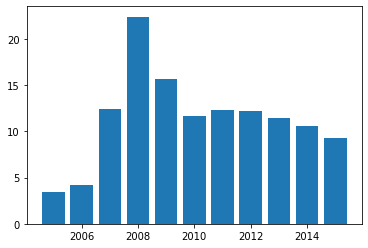

In [29]:
X = range(2005,2016)
Y=[]

for year in X:
    year_df = Closing_Odds[Closing_Odds['year']==year]
    
    Y.append(100*len(year_df[year_df['condition']==True])/len(year_df))
#print(Y)
pl.bar(list(X),Y)
pl.show()

22.4% of 2008 games are worth betting on following our strategy. That's a huge bump from all other years, all close to the average 11.7% except for 2009 at 15%. This is quite suprising, since most of 2008-09 games have little betting odds to chose from, and we just saw a correlation between our condition and n_odds. We shall go to the bottom of it.

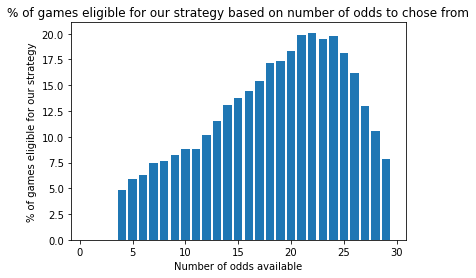

In [30]:
X = range(1,30)
Y=[]

for n_odds in X:
    n_odds_df = Closing_Odds[Closing_Odds['n_odds_home_win']==n_odds]
    
    Y.append(100*len(n_odds_df[n_odds_df['condition']==True])/len(n_odds_df))
#print(Y)
pl.bar(list(X),Y)
pl.ylabel('% of games eligible for our strategy')
pl.xlabel('Number of odds available')

pl.title("% of games eligible for our strategy based on number of odds to chose from")
pl.show()

The sweet spot for n_odds is around 21 to 25 different bookmakers. It's a straight line from lower number of choice to this threshold. After 25, the data is less relevant because games having more than 25 bookmakers to pick from are those played in 2015, which we have little of.

### Feature engineering

Since most of our data's columns are unusabe for future sample (due to unknown results and odds), we have to find new ways to circumvent this problem. One way is to create new features based on our existing ones, that we can use for both training and testing examples. 

I will introduce 3 new features : 
- home team's winrate in their last 5 games
- away team's winrate in their last 5 games
- head to head between the 2 opposing teams

In [31]:
def home_team_last_5_wr(df):

    last_5_wr = []

    # Dictionary to track the last 5 games of each home team
    team_history = {}

    for _, row in df.iterrows():
        home_team = row['home_team']
        result = row['result']

        # Initialize team history if not present
        if home_team not in team_history:
            team_history[home_team] = []

        # Calculate win rate for the last 5 games
        recent_results = team_history[home_team]
        if len(recent_results) > 0:
            wr = sum(recent_results) / len(recent_results)
            #wr = recent_results.count(1) / len(recent_results)
            '''   
            Different things measured by different winrates.
            Here I've chosen to compute losses as -1 instead of 0 (that would be the second line)
            to gather more informations about teams' recent form
            '''     
        else:
            wr = 0
        last_5_wr.append(wr)

        # Update the team's history with the current game result
        if len(recent_results) == 5:
            recent_results.pop(0)  # Remove the oldest result
        recent_results.append(result)

    return pd.Series(last_5_wr, name='home_last_5_wr')

Last_5_H_WR = home_team_last_5_wr(Closing_Odds)
#Last_5_H_WR

In [32]:
def away_team_last_5_wr(df):

    last_5_wr = []

    # Dictionary to track the last 5 games of each team
    team_history = {}

    for _, row in df.iterrows():
        away_team = row['away_team']
        result = row['result']

        # Initialize team history if not present
        if away_team not in team_history:
            team_history[away_team] = []

        # Calculate win rate for the last 5 games
        recent_results = team_history[away_team]
        if len(recent_results) > 0:
            wr = sum(recent_results) / len(recent_results)
            
        else:
            wr = 0
        last_5_wr.append(wr)

        if len(recent_results) == 5:
            recent_results.pop(0)  
        recent_results.append(result)

    return pd.Series(last_5_wr, name='away_last_5_wr')

Last_5_A_WR = away_team_last_5_wr(Closing_Odds)
#Last_5_A_WR

In [33]:
Closing_Odds.insert(11,'home_last_5_wr',Last_5_H_WR)
Closing_Odds.insert(12,'away_last_5_wr',Last_5_A_WR)
Closing_Odds

,match_id,country,league,match_date,year,home_team,home_score,away_team,away_score,result,...,max_odds_home_win,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win,condition
0,170088,England,England: Premier League,2005-01-01,2005,Liverpool,0,Chelsea,1,-1,...,3.20,3.25,2.29,Paddy Power,Sportingbet,Expekt,9,9,9,False
1,170089,England,England: Premier League,2005-01-01,2005,Fulham,3,Crystal Palace,1,1,...,2.04,3.30,4.15,Pinnacle Sports,bet-at-home,Expekt,9,9,9,False
2,170090,England,England: Premier League,2005-01-01,2005,Aston Villa,1,Blackburn,0,1,...,2.00,3.40,4.50,Pinnacle Sports,Paddy Power,Sportingbet,9,9,9,False
3,170091,England,England: Premier League,2005-01-01,2005,Bolton,1,West Brom,1,0,...,1.67,3.57,6.27,Coral,Pinnacle Sports,Pinnacle Sports,9,9,9,False
4,170092,England,England: Premier League,2005-01-01,2005,Charlton,1,Arsenal,3,-1,...,7.00,3.60,1.62,Expekt,Paddy Power,bet365,9,9,9,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479435,876806,World,World: Club Friendly,2015-06-30,2015,St. Gallen,1,Wacker Innsbruck,2,-1,...,1.83,4.20,4.33,188BET,bet365,Ladbrokes,24,24,24,False
479436,876807,World,World: Club Friendly,2015-06-30,2015,SW Harelbeke,1,Waregem,1,0,...,19.00,9.00,1.13,BetVictor,bet365,Titanbet,17,17,17,False
479437,876808,World,World: Club Friendly,2015-06-30,2015,Torhout,0,Club Brugge,5,-1,...,22.00,15.00,1.05,BetVictor,Jetbull,BetVictor,16,16,16,False
479438,876809,World,World: Club Friendly,2015-06-30,2015,Tournai,0,Mouscron Peruwelz,3,-1,...,34.00,12.00,1.10,Sportingbet,Betclic,Paddy Power,7,7,7,False


When it comes to the Head to Head feature, there are many ways we could go about it, as there are a lot of ways to calculate head to head between Team A vs Team B:
- consider every game between A and B regardless of who's at home/away
- only consider the games where A is at home (if the current game under consideration is played with A at home)
- consider the last X games to weigh more heavily on current form
- take all games into account (as some teams have never won at in a certain stadium for a very long time it might have a bigger statistical impact)


For this use case, we probably could choose every other one, without much difference. 
I decided to filter past games on Home/Away (meaning if the game under consideration is A VS B, we don't compute B VS A past results to the H2H) but not on dates (meaning we take every past games and not only the last X).

In [34]:
def head_to_head_winrate(df):
 

    # Initialize a column to store the head-to-head win rate
    h2h_winrate = []

    # Dictionary to track the last 5 head-to-head results for each home-away team pair
    h2h_history = {}

    for _, row in df.iterrows():
        home_team = row['home_team']
        away_team = row['away_team']
        result = row['result']

        # Create a unique key for the head-to-head pair
        matchup_key = (home_team, away_team)

        # Initialize head-to-head history if not present
        if matchup_key not in h2h_history:
            h2h_history[matchup_key] = []

        # Calculate win rate for the previous head-to-head games
        recent_results = h2h_history[matchup_key]
        if len(recent_results) > 0:
            winrate = sum(recent_results) / len(recent_results)
        else:
            winrate = 0
        
        # >0 winrate means the home team won more than it lost, <0 means the away team got the upper hand
        # thanks to our result column definition
        
        h2h_winrate.append(winrate)
        recent_results.append(result)

    # Add the calculated winrate as a new column in the DataFrame
    return pd.Series(h2h_winrate, name='HeadToHeadhomeWinRate')

Closing_Odds.insert(13,'head_to_head',head_to_head_winrate(Closing_Odds))
Closing_Odds

,match_id,country,league,match_date,year,home_team,home_score,away_team,away_score,result,...,max_odds_home_win,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win,condition
0,170088,England,England: Premier League,2005-01-01,2005,Liverpool,0,Chelsea,1,-1,...,3.20,3.25,2.29,Paddy Power,Sportingbet,Expekt,9,9,9,False
1,170089,England,England: Premier League,2005-01-01,2005,Fulham,3,Crystal Palace,1,1,...,2.04,3.30,4.15,Pinnacle Sports,bet-at-home,Expekt,9,9,9,False
2,170090,England,England: Premier League,2005-01-01,2005,Aston Villa,1,Blackburn,0,1,...,2.00,3.40,4.50,Pinnacle Sports,Paddy Power,Sportingbet,9,9,9,False
3,170091,England,England: Premier League,2005-01-01,2005,Bolton,1,West Brom,1,0,...,1.67,3.57,6.27,Coral,Pinnacle Sports,Pinnacle Sports,9,9,9,False
4,170092,England,England: Premier League,2005-01-01,2005,Charlton,1,Arsenal,3,-1,...,7.00,3.60,1.62,Expekt,Paddy Power,bet365,9,9,9,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479435,876806,World,World: Club Friendly,2015-06-30,2015,St. Gallen,1,Wacker Innsbruck,2,-1,...,1.83,4.20,4.33,188BET,bet365,Ladbrokes,24,24,24,False
479436,876807,World,World: Club Friendly,2015-06-30,2015,SW Harelbeke,1,Waregem,1,0,...,19.00,9.00,1.13,BetVictor,bet365,Titanbet,17,17,17,False
479437,876808,World,World: Club Friendly,2015-06-30,2015,Torhout,0,Club Brugge,5,-1,...,22.00,15.00,1.05,BetVictor,Jetbull,BetVictor,16,16,16,False
479438,876809,World,World: Club Friendly,2015-06-30,2015,Tournai,0,Mouscron Peruwelz,3,-1,...,34.00,12.00,1.10,Sportingbet,Betclic,Paddy Power,7,7,7,False


For a new engineered feature, we could convert the n_odds to a different meaning rendering it usesfull with our constraint.

We hypothesize that n_odds are most importantly a function of time and league, and we can predict a game's n_odds accurately enough based on previous n_odds from games played in the same league in the same year or season.

Let's map the std of n_odds in the PL based on seasons and test this hypothesis.

C:\Users\remib\AppData\Local\Temp/ipykernel_15984/3086775110.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  pl.boxplot(Y,labels=X)


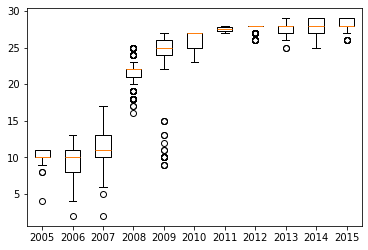

In [35]:
X = range(2005,2016)
Y=[]

for year in X:
    # Take games from 1st June of year X to 1st June of year X+1 in the PL
    # and map the deviation of n_odds (same averages for H/D/A)
    
    season_df = Closing_Odds[(Closing_Odds['match_date']>=f"{year-1}-06-01")&
                             (Closing_Odds['match_date']<=f"{year}-06-01")&
                             (Closing_Odds['league']=="England: Premier League")]
    Y.append(list(season_df['n_odds_draw']))

pl.boxplot(Y,labels=X)
pl.show()

#for k in Y:
#    print(np.std(k))

The results aren't decisive enough to conclude for me, the max span of data is quite high in some games. I could choose to go with it, but I am afraid the std isn't low enough. Plus, we only tried it on the PL, and we can't reallistically test it for all 800 leagues, so we should just forget about it and try other ideas.

Other candidates for new features included :
- home team last X goals scored/conceded/difference
- away team last X goals scored/conceded/difference
- team ranking accross leagues, although that would probably require a lot of time and energy, only to fall into the trap of playing into the bookmakers game the paper warned us about (which is to try to anticipate the result of a game ourselves)

#### Mapping catergorical data to numerical

Since more than half of our columns are categorical, we could simply transform some of our data to numerical so we can use them in our model.

In [36]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
Closing_Odds['country_encoded'] = encoder.fit_transform(Closing_Odds[['country']])
print(max(Closing_Odds['country_encoded']))

128.0


In [37]:
Closing_Odds['league_encoded'] = encoder.fit_transform(Closing_Odds[['league']])
print(max(Closing_Odds['league_encoded']))

817.0


In [38]:
bookies = set(Closing_Odds['top_bookie_home_win'])

bookie_to_number = {}
index=0
for bookie in bookies:
    bookie_to_number[bookie]=index
    index+=1

columns_to_map = ['top_bookie_home_win', 'top_bookie_draw', 'top_bookie_away_win']
Closing_Odds[columns_to_map] = Closing_Odds[columns_to_map].replace(bookie_to_number)

C:\Users\remib\AppData\Local\Temp/ipykernel_15984/3219918829.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Closing_Odds[columns_to_map] = Closing_Odds[columns_to_map].replace(bookie_to_number)


We fit countries, leagues and bookmakers to numbers going from 0-128, 0-817 and 0-29 respectively

It's now time to chose a model according to our use case and constraints, train it, evaluate it and report on the results.

## III - Model Choice

### Static vs Dynamic Classification strategies

#### 1 - Static  

The goal with this strategy is to train a model with data we know are anterior to our validation/test samples. That way we make sure we don't break the rules related to match dates.

We also only take into account features we can use both for training AND testing. Meaning we simply discard odds data, results, goal difference ...

It's a first approximation, we shall see whether or not to improve the model based on preliminary results, and find ways to include more data, or new ways of slicing data to mitigate issues and biases.

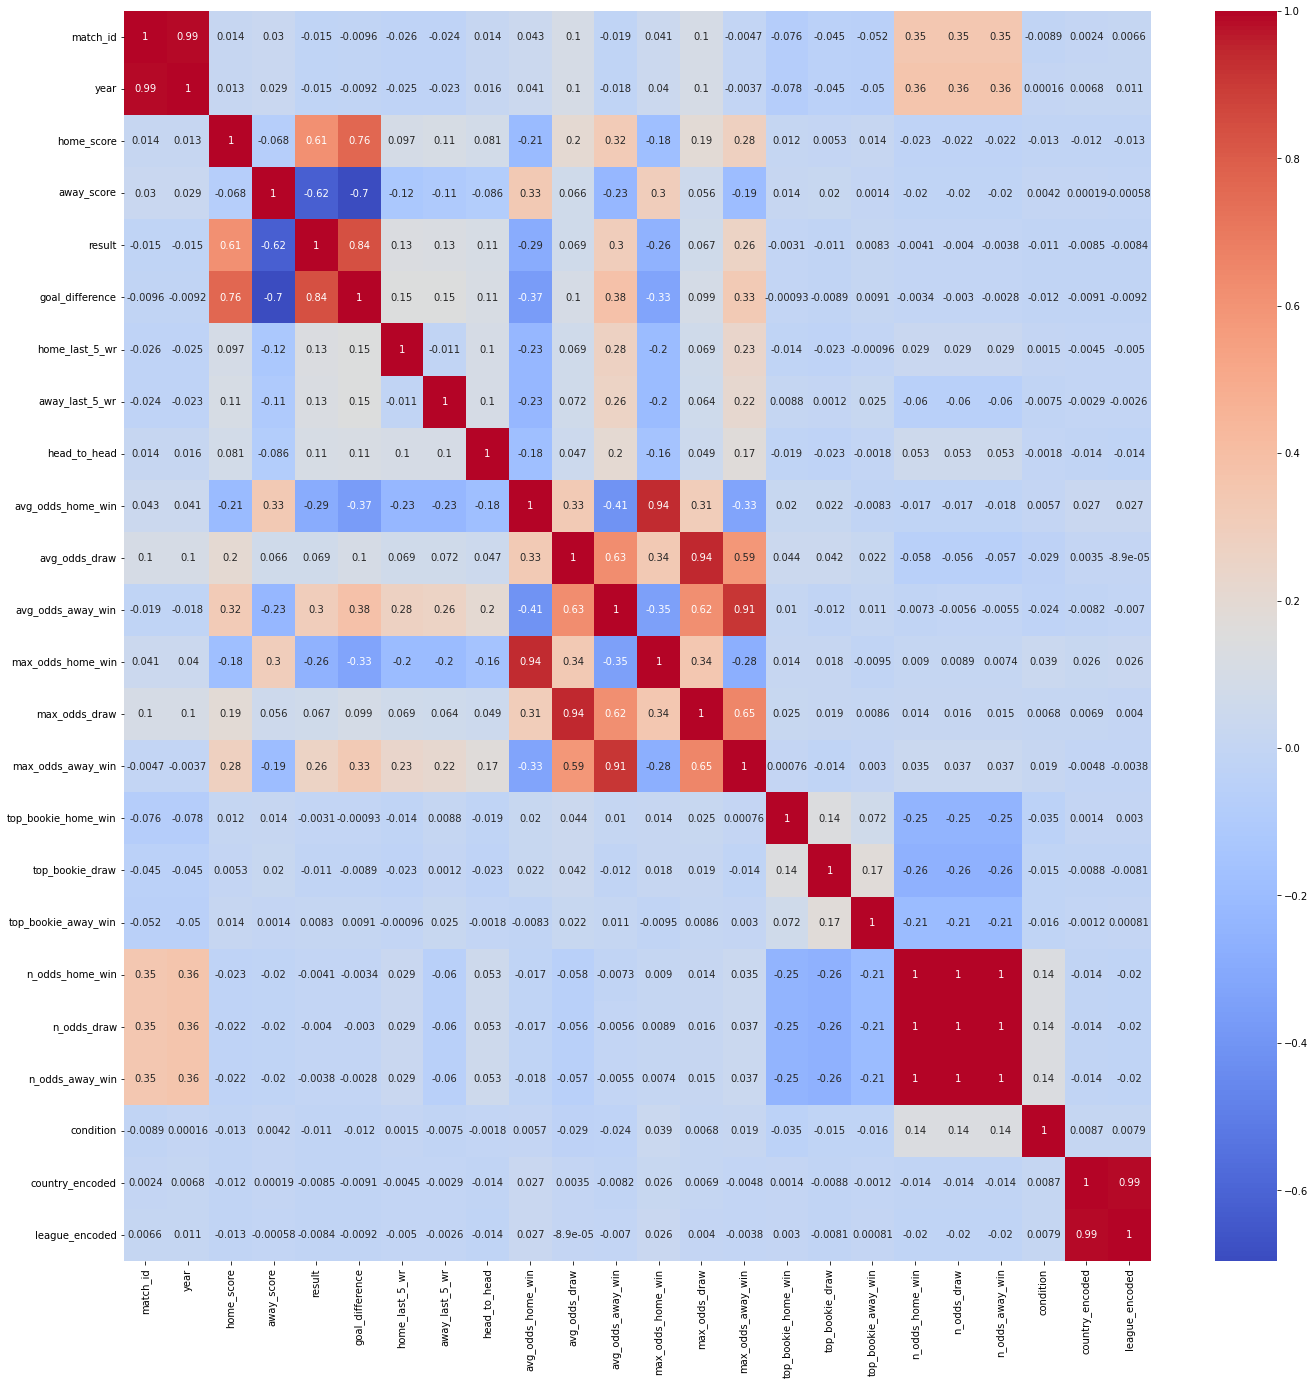

In [39]:
Numerical_data = Closing_Odds.drop(['match_date',"league","country","home_team","away_team"],axis=1)

pl.figure(figsize=(23,23))
sns.heatmap(Numerical_data.corr(), annot=True, cmap='coolwarm')
pl.show()

In [40]:
fixed_training_columns = ([ 'country_encoded', 'league_encoded',  'match_id','home_last_5_wr', 
                           'away_last_5_wr', 'head_to_head'])

AUC-ROC: 0.5202


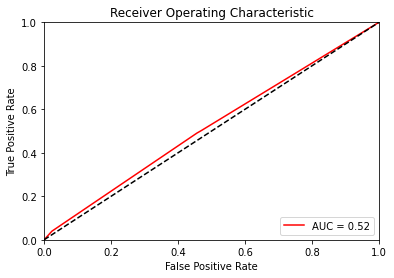

              precision    recall  f1-score   support

       False       0.90      0.54      0.68    128618
        True       0.11      0.49      0.18     15214

    accuracy                           0.54    143832
   macro avg       0.51      0.52      0.43    143832
weighted avg       0.82      0.54      0.63    143832

[0.00438304 0.10695399 0.88727683 0.         0.00138614 0.        ]


In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report
import sklearn.metrics as metrics


# Split our data into features and labels
X = Closing_Odds[fixed_training_columns]
y = Closing_Odds['condition']

# Split into train/test sets with the last 30% of games as testing and the first 70% as training
# By spliting our data by date like that, we can bypass the potential error of using future data to predict previous games
# That way, we are 100% sure not to commit that mistake. There are other problems that come with it we will discuss later.

threshold = int(len(X)*.7)

X_train = X[:threshold]
X_test = X[threshold:]
y_train = y[:threshold]
y_test = y[threshold:]


# Let's take a classic Decision Tree for now. Explainable, handles classs imbalance and intuitive 
model = DecisionTreeClassifier(random_state = 77, class_weight='balanced', max_depth=4)

# Train the model
model.fit(X_train, y_train)

# Predict probabilities for AUC-ROC
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)
auc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC-ROC: {auc:.4f}')

pl.title('Receiver Operating Characteristic')
pl.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
pl.legend(loc = 'lower right')
pl.plot([0, 1], [0, 1],color = 'black',linestyle='--')
pl.xlim([0, 1])
pl.ylim([0, 1])
pl.ylabel('True Positive Rate')
pl.xlabel('False Positive Rate')
pl.show()

# Also, print a classification report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(model.feature_importances_)

This model has an AUC of .52, and it retrieves 49% of the games fulfilling the paper's condition. This is a great first step, and a gives us hope that with a better data pipeline, we can leverage more data (odds, mainly) into the training/testing processes to bolster these results in the future.

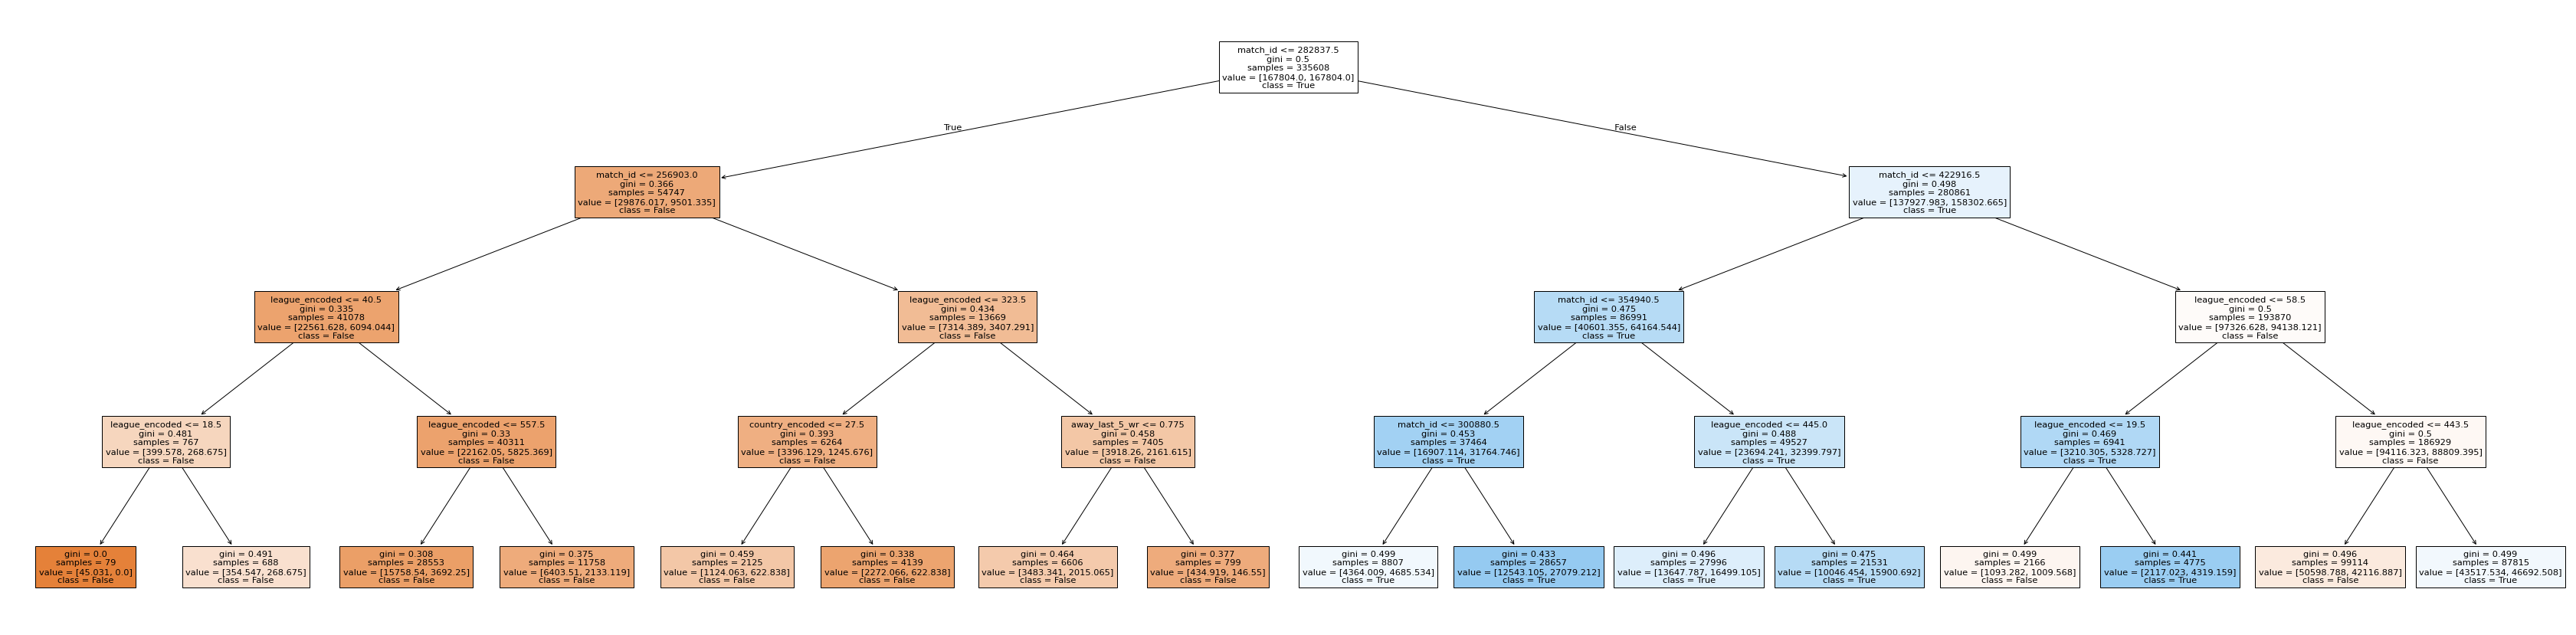

In [42]:
fig = pl.figure(figsize=(60,15))
_ = tree.plot_tree(model,feature_names=X.columns,class_names=['False','True'], filled=True)

### 2 - Dynamic

For the second model, the thought process is a little different.

I still haven't find a way to include data to training if the same columns aren't included in the test/validation samples, so the odds and results are still excluded, but I tried to overcome the time constraint in a different way, that probably ressembles what betting company do (or at least that's what I think they do).

By using dynamic training processes, we can leverage data better. The idea is to select random games from our dataset as validation games (so we don't only take the last games in time) and for each validation game, we slice our original dataset to include only past games, and train a new model each time.

Unfortunately, I couldn't get it to work (or maybe my theory clashes with the reality and simply would never work) but I believe this way of thinking might yield potential. The code I arrived at just takes too long to run.

In [47]:
from sklearn.ensemble import RandomForestClassifier

# We simulate the fact that such a model would only work with some past data that is untouched and not subject to validation
# That way, the latest game we take as test sample would still have 1000 games played prior to it to train a model on
starting_data = 1000


# Shuffle the DataFrame to create randomness
df_shuffled = pd.concat([Closing_Odds.copy()[:starting_data],Closing_Odds.copy()[starting_data:].sample(frac=1, random_state=42)])



# Split the DataFrame : 10% of the starting dataset as test, 10% as val, both taken from games played after the first 1000 
# Rest of it (80%) as remaining games, from which training data will be selected based on val/test game date.
test_val_sizes = int(len(df_shuffled)*.10)


test_games = df_shuffled.iloc[starting_data:test_val_sizes].sort_values(by=['match_id'])
validation_games = df_shuffled.iloc[starting_data+test_val_sizes:starting_data+test_val_sizes * 2].sort_values(by=['match_id'])
remaining_games = pd.concat([df_shuffled[:starting_data],
                             df_shuffled.iloc[starting_data+test_val_sizes * 2:]]).sort_values(by=['match_id'])


# Initialize results
validation_predictions = []
validation_truth = []

# Dynamic training for validation games
for _, game in validation_games.iterrows():
    
    # Slice training data to include only games before the current game's date
    training_data = remaining_games[remaining_games['match_date'] < game['match_date']]
    
    # Training features and target
    X_train = training_data[fixed_training_columns]    
    y_train = training_data['condition']
   
    # Validation features
    X_val = game[fixed_training_columns].to_frame().T

    y_val = game['condition']
    
    # Train model
    model = DecisionTreeClassifier(random_state=42, max_depth=3)
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_val)
    validation_predictions.append(y_pred[0])
    validation_truth.append(y_val)

# Evaluate validation results
print(classification_report(validation_truth, validation_predictions))


KeyboardInterrupt: 

# Conclusion 

We arrived at a statisfying conclusion. It is possible to predict somewhat accurately which games are prone to have +EV when betting, before knowing what the odds are.

I guess what's next for me is to make a fortune before bookmakers adjust their models accordingly, BYE !